In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (15,5)
pd.set_option('display.max_columns', None)


def calculate_count_ocurrences_in_genre(df, genre):
    return df[genre].value_counts()[1]

def calculate_count_ocurrences(df):
    names = ["unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary",
             "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller",
             "War", "Western"]
    ocurrences = []
    for name in names:
        ocurrences.append(calculate_count_ocurrences_in_genre(df, name))
    return np.asarray(names), np.asarray(ocurrences)
    



BASE_PATH = "../ml-100k"

ratings_column_names = ["user_id", "item_id", "rating", "timestamp"]
item_genres_column_names = ["genre", "id"]
item_information_column_names = ["item_id", "item_name", "date", "none", "url", "unknown", "Action", "Adventure",
                           "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama",
                           "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance",
                           "Sci-Fi", "Thriller", "War", "Western"]

u_data_path = os.path.join(BASE_PATH, "u.data")
u_genre = os.path.join(BASE_PATH, "u.genre")
u_item = os.path.join(BASE_PATH, "u.item")

data = pd.read_csv(u_data_path, sep="\t", header=None, names=["user_id", "item_id", "rating", "timestamp"])
genres = pd.read_csv(u_genre, sep="|", header=None, names=item_genres_column_names)
item_information = pd.read_csv(u_item, sep="|", header=None, names=item_information_column_names)

In [2]:
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
genres.head()

,genre,id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [4]:
item_information.head()

,item_id,item_name,date,none,url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


Computar número de películas en cada género.

# Cálculo de las frecuencias de cada género

Se trata de visualizar de manera sencilla el número de películas dentro de cada género (como cada película puede pertenecer a más de una categoría, la suma no es igual al número total de películas).

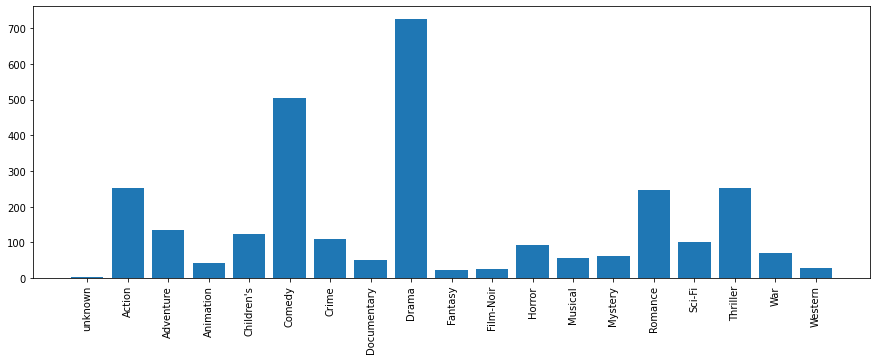

In [5]:
genre_names, genre_frequencies = calculate_count_ocurrences(item_information)

plt.bar(genre_names, genre_frequencies)
plt.xticks(genre_names, rotation='vertical')
plt.show()

Podemos ver que la categoría más representada (casi un 50%) es la de Drama, seguida por la Comedia. 

# Construcción de matriz de ratings

Se construye la matriz de ratings y se extraen estadísticos fundamentales (media de voto en todos los ratings, media de voto en cada película, distribución de ratings por usuario, distribución de ratings de los ítems, etc.).

In [6]:
r = data.pivot(index='user_id', columns='item_id', values='rating').values

In [7]:
r_shape = r.shape

In [9]:
print("Rating matrix shape: ", r_shape)
print("Number of missing values: ", np.sum(np.isnan(r)))
print("Percentage of missing values: ", np.sum(np.isnan(r)) / (r_shape[0] * r_shape[1]))

Rating matrix shape:  (943, 1682)
Number of missing values:  1486126
Percentage of missing values:  0.9369533063577546


La matriz de ratings, R, de dimensión 943 x 1682, es decir 943 usuarios y 1682 items. Por otro lado, vemos que un 93.7 % de los valores de la matriz son "missing values". Es decir, se trata de una matriz claramente "sparse", algo evidente al tratarse de una matriz de ratings. El número de ratings es de 100000 (de ahí el nombre del dataset).

Veamos a continuación algunos estadísticos interesantes para hacernos una idea de la estructura de la matriz.

In [10]:
print("Average rating in all Movielens 100K: ", np.nanmean(r))
print("Max / Min rating: ", np.nanmin(r), np.nanmax(r))

Average rating in all Movielens 100K:  3.52986
Max / Min rating:  1.0 5.0


In [12]:
number_of_ratings_per_user = np.sum(~ np.isnan(r), axis=1)

In [13]:
print("Mean of ratings per user: ", np.mean(number_of_ratings_per_user))
print("Quantiles of ratings per user: ", np.quantile(number_of_ratings_per_user,
                                                     q=[0.0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.]))

Mean of ratings per user:  106.04453870625663
Quantiles of ratings per user:  [ 20.   21.   33.   65.  148.  310.6 737. ]


(array([172.,  82.,  59.,  56.,  47.,  48.,  33.,  31.,  20.,  12.,  19.,
         25.,  23.,  14.,  19.,  14.,  18.,  21.,  16.,  14.,   9.,   9.,
         13.,  12.,   8.,  10.,   7.,   8.,  10.,  10.,   9.,   4.,   3.,
          6.,   4.,  11.,   6.,   2.,   5.,   5.,   3.,   4.,   5.,   3.,
          1.,   0.,   1.,   5.,   2.,   1.,   2.,   4.,   3.,   2.,   1.,
          0.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,   2.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 20.  ,  27.17,  34.34,  41.51,  48.68,  55.85,  63.02,  70.19,
         77.36,  84.53,  91.7 ,  98.87, 106.04, 113.21, 120.38, 127.55,
        134.72, 141.89, 149.06, 156.23, 163.4 , 170.57, 177.74, 184.91,
        192.08, 199.25, 206.42, 213.59, 220.76, 227.93, 235.1 , 242.27,
        249.44, 256.61, 263.78

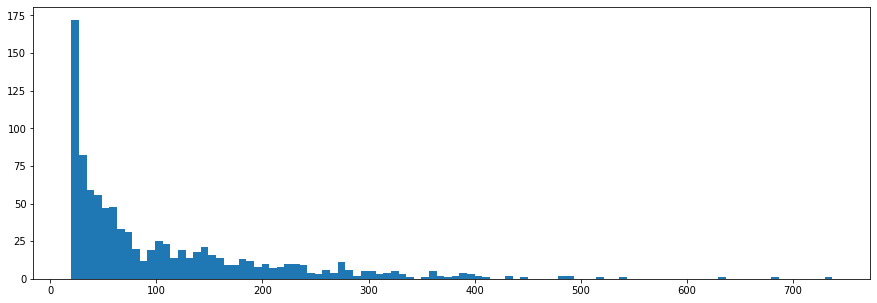

In [14]:
plt.hist(number_of_ratings_per_user, bins=100)

In [16]:
number_of_ratings_per_item = np.sum(~ np.isnan(r), axis=0)

In [17]:
print("Mean of ratings per item: ", np.mean(number_of_ratings_per_item))
print("Quantiles of ratings per item: ", np.quantile(number_of_ratings_per_item,
                                                     q=[0.0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.]))

Mean of ratings per item:  59.45303210463734
Quantiles of ratings per item:  [  1.     1.     6.    27.    80.   229.85 583.  ]


(array([423., 188., 114.,  85.,  74.,  55.,  58.,  65.,  44.,  40.,  37.,
         38.,  28.,  31.,  21.,  28.,  15.,  22.,  10.,  19.,  15.,  30.,
         10.,  13.,   7.,  15.,  10.,  10.,  10.,  19.,  11.,   6.,   6.,
          6.,   5.,   8.,   5.,  12.,   4.,   4.,   3.,   7.,   7.,   4.,
          3.,   4.,   1.,   5.,   2.,   2.,   7.,   6.,   0.,   1.,   3.,
          2.,   1.,   1.,   1.,   2.,   0.,   0.,   2.,   0.,   1.,   1.,
          1.,   2.,   0.,   0.,   1.,   1.,   0.,   2.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   1.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  1.  ,   6.82,  12.64,  18.46,  24.28,  30.1 ,  35.92,  41.74,
         47.56,  53.38,  59.2 ,  65.02,  70.84,  76.66,  82.48,  88.3 ,
         94.12,  99.94, 105.76, 111.58, 117.4 , 123.22, 129.04, 134.86,
        140.68, 146.5 , 152.32, 158.14, 163.96, 169.78, 175.6 , 181.42,
        187.24, 193.06, 198.88

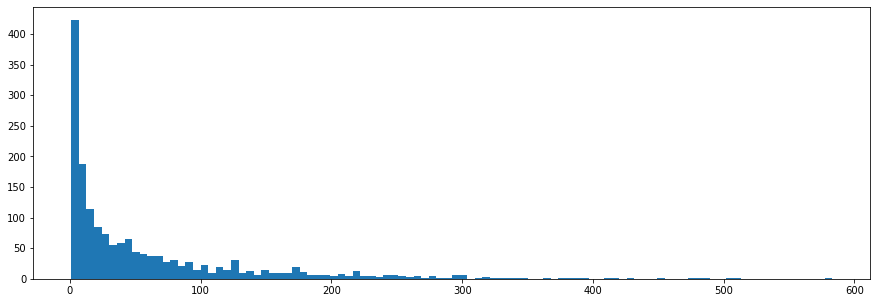

In [18]:
plt.hist(number_of_ratings_per_item, bins=100)

Se puede interpretar como la clásica distribución longtail, donde tenemos que la mayor parte de ítems tiene muy poco seguimiento por parte de la comunidad, mientras que hay un subconjunto selecto que tiene mucho seguimientos. Vamos a verlo con otro plot, en este caso intentando mostrar esta popularidad como el número de ratings recibidos.

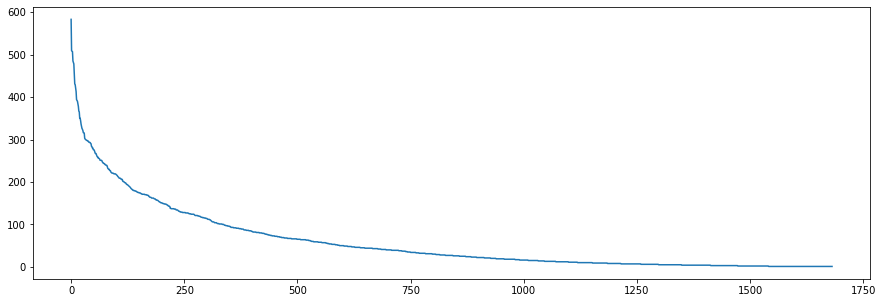

In [19]:
plt.plot(np.sort(number_of_ratings_per_item)[::-1])

Como podemos ver, la "popularidad" entre los ítems es claramente asimétrica, existiendo ítems con una notoriedad muy alta y otros que tienen muy poco seguimiento. Una de las claves de la "serendipia" es conseguir bucear en la "long-tail", en la región desconocida, para poder encontrar recomendaciones que sorprendan al usuario.

# Generate train and test

In [20]:
def generate_new_matrix(selected_rows):
    r = np.zeros((943, 1682))
    r[:] = np.nan
    for i in selected_rows:
        r[i[0] - 1][i[1] - 1] = i[2]
    return r

In [21]:
train, test = train_test_split(data, test_size=0.1, random_state=178, shuffle=True)

In [22]:
r_train, r_test = generate_new_matrix(train.values), generate_new_matrix(test.values)

In [23]:
print(np.sum(~ np.isnan(r_train)))
print(np.sum(~ np.isnan(r_test)))

90000
10000


Generamos un conjunto de entrenamiento y de test que usaremos durante toda la investigación. La idea es que los resultados se comparen con el conjunto de test, de modo que todos los resultados sean comparables.

In [25]:
train.head()

,user_id,item_id,rating,timestamp
24340,85,423,4,879454046
3500,290,71,5,880473667
36543,152,692,5,880149963
55062,759,678,2,875227742
3534,92,928,3,886443582


In [26]:
test.head()

,user_id,item_id,rating,timestamp
30807,301,39,3,882076292
33104,288,121,2,886893063
2327,234,614,3,892334609
96764,387,581,4,886483394
87360,544,346,4,884795135


In [27]:
train.to_csv("../data/train.csv", index=False)
test.to_csv("../data/test.csv", index=False)